In [16]:
import nest
import pickle
import matplotlib.pyplot as plt 
from matplotlib import gridspec
import numpy as np
import pandas as pd
import textwrap
import nest.random

*** Initial simulation ***

[ 100% ] Model time: 1000.0 ms, Real-time factor: 0.4236


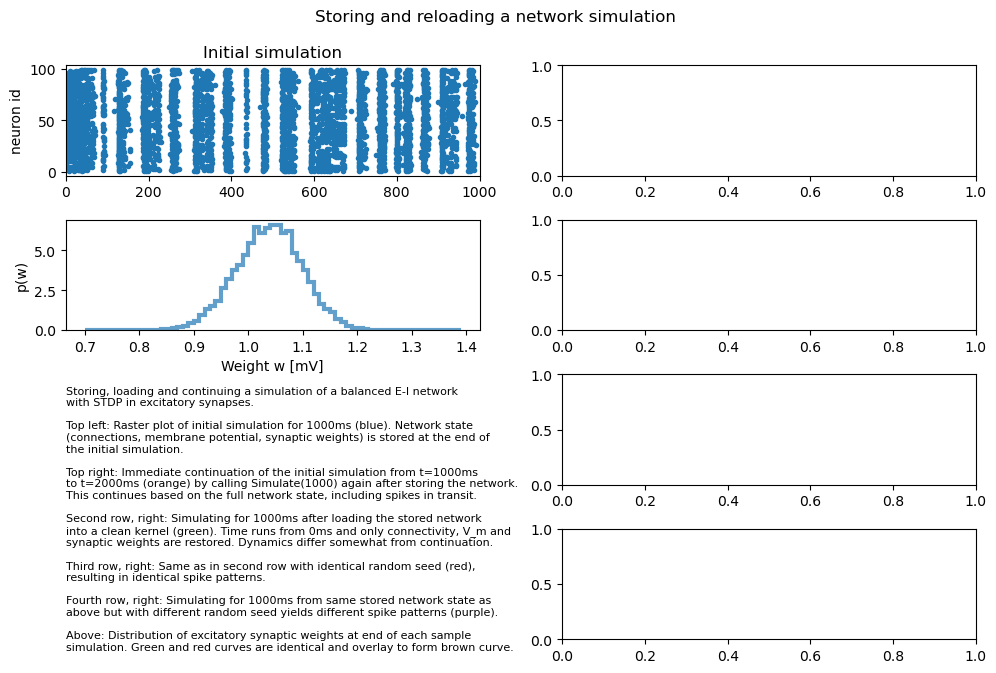


*** Storing simulation ... done ***


*** Continuing simulation ***

[  50% ] Model time: 1490.0 ms, Real-time factor: 0.4260

<Figure size 640x480 with 0 Axes>

[ 100% ] Model time: 2000.0 ms, Real-time factor: 0.4084

*** Reloading and resuming simulation ***


<Figure size 640x480 with 0 Axes>


*** Reloading and resuming simulation (same seed) ***


<Figure size 640x480 with 0 Axes>


*** Reloading and resuming simulation (different seed) ***


<Figure size 640x480 with 0 Axes>

In [17]:
class EINetwork:
    """
    A simple balanced random network with plastic excitatory synapses.

    The model is provided as a non-trivial example for storing and restoring.
    """

    def __init__(self):
        self.nI = 500
        self.nE = 4 * self.nI
        self.n = self.nE + self.nI

        self.JE = 1.0
        self.JI = -4 * self.JE
        self.indeg_e = 200
        self.indeg_i = 50

        self.neuron_model = "iaf_psc_delta"

        # Create synapse models so we can extract specific connection information
        nest.CopyModel("stdp_synapse_hom", "e_syn", {"Wmax": 2 * self.JE})
        nest.CopyModel("static_synapse", "i_syn")

        self.nrn_params = {"V_m": nest.random.normal(-65.0, 5.0)}
        self.poisson_rate = 800.0

    def build(self):
        """
        Construct network from scratch, including instrumentation.
        """

        self.e_neurons = nest.Create(self.neuron_model, n=self.nE, params=self.nrn_params)
        self.i_neurons = nest.Create(self.neuron_model, n=self.nI, params=self.nrn_params)
        self.neurons = self.e_neurons + self.i_neurons

        self.pg = nest.Create("poisson_generator", {"rate": self.poisson_rate})
        self.sr = nest.Create("spike_recorder")

        nest.Connect(
            self.e_neurons,
            self.neurons,
            {"rule": "fixed_indegree", "indegree": self.indeg_e},
            {"synapse_model": "e_syn", "weight": self.JE},
        )
        nest.Connect(
            self.i_neurons,
            self.neurons,
            {"rule": "fixed_indegree", "indegree": self.indeg_i},
            {"synapse_model": "i_syn", "weight": self.JI},
        )
        nest.Connect(self.pg, self.neurons, "all_to_all", {"weight": self.JE})
        nest.Connect(self.e_neurons, self.sr)

    def store(self, dump_filename):
        """
        Store neuron membrane potential and synaptic weights to given file.
        """

        assert nest.NumProcesses() == 1, "Cannot dump MPI parallel"

        ###############################################################################
        # Build dictionary with relevant network information:
        #
        #   - membrane potential for all neurons in each population
        #   - source, target and weight of all connections
        #
        # Dictionary entries are Pandas Dataframes.
        #
        # Strictly speaking, we would not need to store the weight of the inhibitory
        # synapses since they are fixed, but we do so out of symmetry and to make it
        # easier to add plasticity for inhibitory connections later.

        network = {}
        network["n_vp"] = nest.total_num_virtual_procs
        network["e_nrns"] = self.neurons.get(["V_m"], output="pandas")
        network["i_nrns"] = self.neurons.get(["V_m"], output="pandas")

        network["e_syns"] = nest.GetConnections(synapse_model="e_syn").get(
            ("source", "target", "weight"), output="pandas"
        )
        network["i_syns"] = nest.GetConnections(synapse_model="i_syn").get(
            ("source", "target", "weight"), output="pandas"
        )

        with open(dump_filename, "wb") as f:
            pickle.dump(network, f, pickle.HIGHEST_PROTOCOL)

    def restore(self, dump_filename):
        """
        Restore network from data in file combined with base information in the class.
        """

        assert nest.NumProcesses() == 1, "Cannot load MPI parallel"

        with open(dump_filename, "rb") as f:
            network = pickle.load(f)

        assert network["n_vp"] == nest.total_num_virtual_procs, "N_VP must match"

        ###############################################################################
        # Reconstruct neurons
        # Since NEST does not understand Pandas Series, we must pass the values as
        # NumPy arrays
        self.e_neurons = nest.Create(self.neuron_model, n=self.nE, params={"V_m": network["e_nrns"].V_m.values})
        self.i_neurons = nest.Create(self.neuron_model, n=self.nI, params={"V_m": network["i_nrns"].V_m.values})
        self.neurons = self.e_neurons + self.i_neurons

        ###############################################################################
        # Reconstruct instrumentation
        self.pg = nest.Create("poisson_generator", {"rate": self.poisson_rate})
        self.sr = nest.Create("spike_recorder")

        ###############################################################################
        # Reconstruct connectivity
        nest.Connect(
            network["e_syns"].source.values,
            network["e_syns"].target.values,
            "one_to_one",
            {"synapse_model": "e_syn", "weight": network["e_syns"].weight.values},
        )

        nest.Connect(
            network["i_syns"].source.values,
            network["i_syns"].target.values,
            "one_to_one",
            {"synapse_model": "i_syn", "weight": network["i_syns"].weight.values},
        )

        ###############################################################################
        # Reconnect instruments
        nest.Connect(self.pg, self.neurons, "all_to_all", {"weight": self.JE})
        nest.Connect(self.e_neurons, self.sr)


class DemoPlot:
    """
    Create demonstration figure for effect of storing and restoring a network.

    The figure shows raster plots for five different runs, a PSTH for the
    initial 1 s simulation and PSTHs for all 1 s continuations, and weight
    histograms.
    """

    def __init__(self):
        self._colors = [c["color"] for c in plt.rcParams["axes.prop_cycle"]]
        self._next_line = 0

        plt.rcParams.update({"font.size": 10})
        self.fig = plt.figure(figsize=(10, 7), constrained_layout=False)

        gs = gridspec.GridSpec(4, 2, bottom=0.08, top=0.9, left=0.07, right=0.98, wspace=0.2, hspace=0.4)
        self.rasters = [self.fig.add_subplot(gs[0, 0])] + [self.fig.add_subplot(gs[n, 1]) for n in range(4)]
        self.weights = self.fig.add_subplot(gs[1, 0])
        self.comment = self.fig.add_subplot(gs[2:, 0])

        self.fig.suptitle("Storing and reloading a network simulation")
        self.comment.set_axis_off()
        self.comment.text(
            0,
            1,
            textwrap.dedent(
                """
            Storing, loading and continuing a simulation of a balanced E-I network
            with STDP in excitatory synapses.

            Top left: Raster plot of initial simulation for 1000ms (blue). Network state
            (connections, membrane potential, synaptic weights) is stored at the end of
            the initial simulation.

            Top right: Immediate continuation of the initial simulation from t=1000ms
            to t=2000ms (orange) by calling Simulate(1000) again after storing the network.
            This continues based on the full network state, including spikes in transit.

            Second row, right: Simulating for 1000ms after loading the stored network
            into a clean kernel (green). Time runs from 0ms and only connectivity, V_m and
            synaptic weights are restored. Dynamics differ somewhat from continuation.

            Third row, right: Same as in second row with identical random seed (red),
            resulting in identical spike patterns.

            Fourth row, right: Simulating for 1000ms from same stored network state as
            above but with different random seed yields different spike patterns (purple).

            Above: Distribution of excitatory synaptic weights at end of each sample
            simulation. Green and red curves are identical and overlay to form brown curve."""
            ),
            transform=self.comment.transAxes,
            fontsize=8,
            verticalalignment="top",
        )

    def add_to_plot(self, net, n_max=100, t_min=0, t_max=1000, lbl=""):
        spks = pd.DataFrame.from_dict(net.sr.get("events"))
        spks = spks.loc[(spks.senders < n_max) & (t_min < spks.times) & (spks.times < t_max)]

        self.rasters[self._next_line].plot(spks.times, spks.senders, ".", color=self._colors[self._next_line])
        self.rasters[self._next_line].set_xlim(t_min, t_max)
        self.rasters[self._next_line].set_title(lbl)
        if 1 < self._next_line < 4:
            self.rasters[self._next_line].set_xticklabels([])
        elif self._next_line == 4:
            self.rasters[self._next_line].set_xlabel("Time [ms]")

        ################################################################################################
        # To save time while plotting, we extract only a subset of connections.
        # For simplicity, we just use a prime-number stepping.
        w = nest.GetConnections(source=net.e_neurons[::41], synapse_model="e_syn").weight
        wbins = np.arange(0.7, 1.4, 0.01)
        self.weights.hist(
            w,
            bins=wbins,
            histtype="step",
            density=True,
            label=lbl,
            color=self._colors[self._next_line],
            alpha=0.7,
            lw=3,
        )

        if self._next_line == 0:
            self.rasters[0].set_ylabel("neuron id")
            self.weights.set_ylabel("p(w)")
            self.weights.set_xlabel("Weight w [mV]")

        plt.draw()
        plt.pause(1e-3)  # allow figure window to draw figure

        self._next_line += 1


if __name__ == "__main__":
    T_sim = 1000

    dplot = DemoPlot()

    ###############################################################################
    # Ensure clean slate and make NEST less chatty
    nest.set_verbosity("M_WARNING")
    nest.ResetKernel()

    ###############################################################################
    # Create network from scratch and simulate 1s.
    nest.local_num_threads = 4
    nest.print_time = True
    ein = EINetwork()
    print("*** Initial simulation ***")
    ein.build()
    nest.Simulate(T_sim)
    dplot.add_to_plot(ein, lbl="Initial simulation")

    ###############################################################################
    # Store network state to file with state after 1s.
    print("\n*** Storing simulation ...", end="", flush=True)
    ein.store("ein_1000.pkl")
    print(" done ***\n")

    ###############################################################################
    # Continue simulation by another 1s.
    print("\n*** Continuing simulation ***")
    nest.Simulate(T_sim)
    dplot.add_to_plot(ein, lbl="Continued simulation", t_min=T_sim, t_max=2 * T_sim)

    ###############################################################################
    # Clear kernel, restore network from file and simulate for 1s.
    print("\n*** Reloading and resuming simulation ***")
    nest.ResetKernel()
    nest.local_num_threads = 4
    ein2 = EINetwork()
    ein2.restore("ein_1000.pkl")
    nest.Simulate(T_sim)
    dplot.add_to_plot(ein2, lbl="Reloaded simulation")

    ###############################################################################
    # Repeat previous step. This shall result in *exactly* the same results as
    # the previous run because we use the same random seed.
    print("\n*** Reloading and resuming simulation (same seed) ***")
    nest.ResetKernel()
    nest.local_num_threads = 4
    ein2 = EINetwork()
    ein2.restore("ein_1000.pkl")
    nest.Simulate(T_sim)
    dplot.add_to_plot(ein2, lbl="Reloaded simulation (same seed)")

    ###############################################################################
    # Clear, restore and simulate again, but now with different random seed.
    # Details in results shall differ from previous run.
    print("\n*** Reloading and resuming simulation (different seed) ***")
    nest.ResetKernel()
    nest.local_num_threads = 4
    nest.rng_seed = 987654321
    ein2 = EINetwork()
    ein2.restore("ein_1000.pkl")
    nest.Simulate(T_sim)
    dplot.add_to_plot(ein2, lbl="Reloaded simulation (different seed)")

    plt.show()